# Stock price prediction. 
# Final project (StonksMaster) for "10 Days of Code" by NIT Durgapur
# Plotting real-time stock data and predicting stock fluctuations using standard algorithms.

In [1]:
import pandas as pd 
import numpy as np 
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from pprint import pprint 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
#Using iexcloud api to get the stock prices of AAPL.
df = pd.read_csv('AAPL2.csv') 

In [3]:
df.tail(5)

,Unnamed: 0,date,open,close,high,low,volume,uOpen,uClose,uHigh,uLow,uVolume,change,changePercent,label,changeOverTime
249,249,2020-10-02,112.89,113.02,115.37,112.22,144711986,112.89,113.02,115.37,112.22,144711986,-3.77,-3.2280,"Oct 2, 20",1.014617
250,250,2020-10-05,113.91,116.50,116.65,113.55,106243839,113.91,116.50,116.65,113.55,106243839,3.48,3.0791,"Oct 5, 20",1.076649
251,251,2020-10-06,115.70,113.16,116.12,112.25,161498212,115.70,113.16,116.12,112.25,161498212,-3.34,-2.8670,"Oct 6, 20",1.017112
252,252,2020-10-07,114.62,115.08,115.55,114.13,96848985,114.62,115.08,115.55,114.13,96848985,1.92,1.6967,"Oct 7, 20",1.051337
253,253,2020-10-08,116.25,114.97,116.40,114.59,83477153,116.25,114.97,116.40,114.59,83477153,-0.11,-0.1000,"Oct 8, 20",0.000000


## Here we have the dataset which contains the opening and closing prices of Apple's stocks for the a year before the current day, day wise. 
## "high" and "low" are the highest and the lowest prices for the stocks for that particular day. 
## "volume" represents the number of stocks that were bought that day. 
## "change percentage" is percentage change of the closing price with respect to the last day's closing price.  

In [4]:
df.date.dtype

dtype('O')

### Here the datatype of "date" column is datetime64. 

### The datetime datatype cannot be passed into a linear regression model. This happens becuase Linear Regression cannot assign coefficient to the date feature as it doesn't comprehend the datetime64 datatype well. Therefore we need is to make the datetime object as numerical value and then feed that into the model. 
### So I would take months of the year, from intuition, as my feature which relates to the date column. 

In [5]:
s = pd.to_datetime(df['date'])
df['date'] = s.dt.strftime("%m")          #This returns 2020-10-2 as 202010 (YearMonth)

In [6]:
df.date = df.date.astype('int64')
df.date.dtype

dtype('int64')

In [7]:
df.tail(5)

,Unnamed: 0,date,open,close,high,low,volume,uOpen,uClose,uHigh,uLow,uVolume,change,changePercent,label,changeOverTime
249,249,10,112.89,113.02,115.37,112.22,144711986,112.89,113.02,115.37,112.22,144711986,-3.77,-3.2280,"Oct 2, 20",1.014617
250,250,10,113.91,116.50,116.65,113.55,106243839,113.91,116.50,116.65,113.55,106243839,3.48,3.0791,"Oct 5, 20",1.076649
251,251,10,115.70,113.16,116.12,112.25,161498212,115.70,113.16,116.12,112.25,161498212,-3.34,-2.8670,"Oct 6, 20",1.017112
252,252,10,114.62,115.08,115.55,114.13,96848985,114.62,115.08,115.55,114.13,96848985,1.92,1.6967,"Oct 7, 20",1.051337
253,253,10,116.25,114.97,116.40,114.59,83477153,116.25,114.97,116.40,114.59,83477153,-0.11,-0.1000,"Oct 8, 20",0.000000


In [8]:
drop_columns = ['volume', 'uOpen', 'uClose', 'uHigh', 'uLow', 
                'uVolume', 'change', 'changePercent', 'label', 'changeOverTime', 'Unnamed: 0']
df.drop(drop_columns, axis = 1, inplace = True)
df.rename(columns = {'date':'YearMonth'})

,YearMonth,open,close,high,low
0,10,56.46,56.10,57.02,56.08
1,10,56.76,56.76,56.95,56.41
2,10,56.98,57.52,57.61,56.83
3,10,58.24,59.05,59.41,58.08
4,10,58.73,58.97,59.53,58.67
...,...,...,...,...,...
249,10,112.89,113.02,115.37,112.22
250,10,113.91,116.50,116.65,113.55
251,10,115.70,113.16,116.12,112.25
252,10,114.62,115.08,115.55,114.13


In [9]:
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    254 non-null    int64  
 1   open    254 non-null    float64
 2   close   254 non-null    float64
 3   high    254 non-null    float64
 4   low     254 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 10.0 KB


None

,date,open,close,high,low
0,10,56.46,56.10,57.02,56.08
1,10,56.76,56.76,56.95,56.41
2,10,56.98,57.52,57.61,56.83
3,10,58.24,59.05,59.41,58.08
4,10,58.73,58.97,59.53,58.67


<AxesSubplot:>

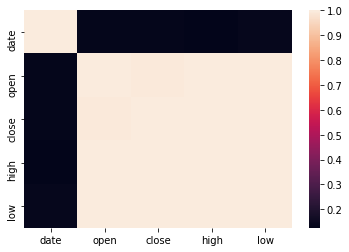

In [10]:
corr = abs(df.corr())
sns.heatmap(corr)

## The correlation map doesn't really give any useful insights apart from what we expeceted from the basic understandings stocks and terms related to it.

In [11]:
df.date = (df.date-df.date.mean())/df.date.std()        #Normalizing the YearMonth column

In [12]:
Y = df.open                                          #Separating the taget variable from the features 
df.drop('open', axis = 1, inplace = True)
X = df

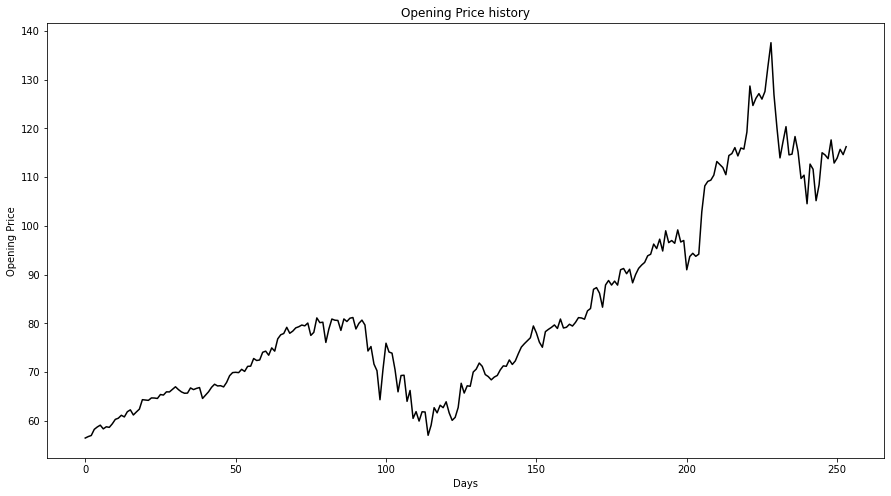

In [13]:
#Plotting history of opening prices for AAPL
plt.figure(figsize=(15,8))
plt.plot(Y, color="black")
plt.title('Opening Price history')
plt.ylabel('Opening Price')
plt.xlabel('Days')
plt.show()

In [14]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state = 14, test_size = .2)

In [15]:
models = [KNeighborsRegressor(), GradientBoostingRegressor(),
          LinearRegression(), SVR(), DecisionTreeRegressor()]
for model in models:
    kfold = KFold(n_splits=5, random_state= 14, shuffle=True)
    result = cross_val_score(model, xtrain, ytrain, 
                             cv=kfold, scoring = 'r2')
    print("For", model, "the r2 score is",result)

For KNeighborsRegressor() the r2 score is [0.99531395 0.98983922 0.99530758 0.99591081 0.99651869]
For GradientBoostingRegressor() the r2 score is [0.99498726 0.99375089 0.99483844 0.99434302 0.99711331]
For LinearRegression() the r2 score is [0.99855103 0.99845096 0.9980742  0.99716475 0.99781439]
For SVR() the r2 score is [0.94473526 0.97043356 0.97297416 0.97565527 0.93424826]
For DecisionTreeRegressor() the r2 score is [0.99338213 0.98873638 0.99527412 0.99419782 0.99581738]


# Linear Regresssion 

In [16]:
lr = LinearRegression(normalize=True, copy_X=True)
lr.fit(xtrain,ytrain)
predict = lr.predict(X)

In [17]:
lr.coef_

array([ 0.10587213, -0.38930633,  0.76292969,  0.63035242])

In [18]:
from sklearn import metrics
print('R^2:',metrics.r2_score(Y, predict))

R^2: 0.9982197890610504


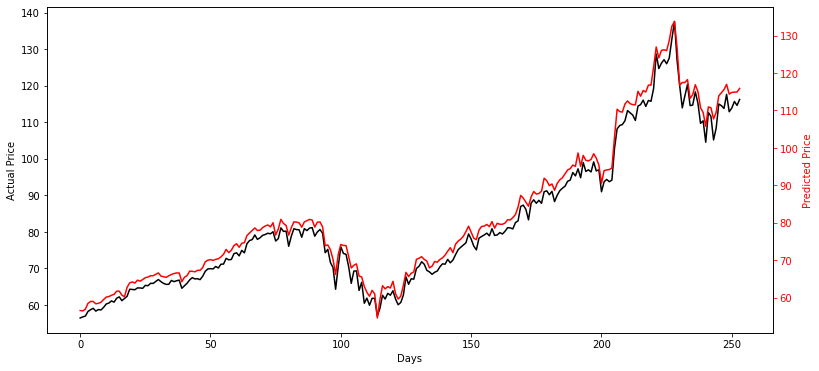

In [19]:
fig, ax1 = plt.subplots(figsize=(13,6))
ax1.set_xlabel('Days')
ax1.set_ylabel('Actual Price')
ax1.plot(Y, color = 'black')

ax2 = ax1.twinx()
ax2.set_ylabel('Predicted Price', color ='red')
ax2.tick_params(axis='y', colors='red')
ax2.plot(predict, color = 'red')
plt.show()

# Gradient Boosting Regressor 

In [20]:
gbr = GradientBoostingRegressor()
pprint(gbr.get_params())                    #Getting the hyperparameters which can be tuned for a better model

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


### Using RandomSearchCV to get range of optimum values of hyperparameters 

In [21]:
random_grid = {'n_estimators': [25,50,100,150,200,300],
               'max_depth': [3,5,10,15],
               'min_samples_leaf': [2, 3, 4],
               'learning_rate' : [.01,.03,.3,1],
               'criterion' : ['friedman_mse','mse']}
pprint(random_grid)

{'criterion': ['friedman_mse', 'mse'],
 'learning_rate': [0.01, 0.03, 0.3, 1],
 'max_depth': [3, 5, 10, 15],
 'min_samples_leaf': [2, 3, 4],
 'n_estimators': [25, 50, 100, 150, 200, 300]}


In [22]:
gbr_random = RandomizedSearchCV(estimator = gbr, param_distributions = random_grid,
                                n_iter = 100, cv = 5, random_state=14, verbose = 0)

In [23]:
gbr_random.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=100,
                   param_distributions={'criterion': ['friedman_mse', 'mse'],
                                        'learning_rate': [0.01, 0.03, 0.3, 1],
                                        'max_depth': [3, 5, 10, 15],
                                        'min_samples_leaf': [2, 3, 4],
                                        'n_estimators': [25, 50, 100, 150, 200,
                                                         300]},
                   random_state=14)

In [24]:
gbr_random.best_params_                     #Best parameters found by the RandomSearchCV

{'n_estimators': 100,
 'min_samples_leaf': 3,
 'max_depth': 15,
 'learning_rate': 0.3,
 'criterion': 'mse'}

### With small datasets and limited number of features GridSearchCV provides a very accurate model. 

In [25]:
grid_param = {'n_estimators': [150,200,100],
               'max_depth': [10,15,17,20],
               'min_samples_leaf': [3, 4,5],
               'learning_rate' : [.1,0.1,0.3],
               'criterion' : ['friedman_mse']}
pprint(grid_param)

{'criterion': ['friedman_mse'],
 'learning_rate': [0.1, 0.1, 0.3],
 'max_depth': [10, 15, 17, 20],
 'min_samples_leaf': [3, 4, 5],
 'n_estimators': [150, 200, 100]}


In [26]:
grid_search =  GridSearchCV(estimator = gbr, param_grid = grid_param, 
                          cv = 3, verbose = 0)

In [27]:
grid_search.fit(xtrain, ytrain)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(),
             param_grid={'criterion': ['friedman_mse'],
                         'learning_rate': [0.1, 0.1, 0.3],
                         'max_depth': [10, 15, 17, 20],
                         'min_samples_leaf': [3, 4, 5],
                         'n_estimators': [150, 200, 100]})

In [28]:
grid_search.best_params_                     #These are the best parameters for the Gradient Boosting Regressor 

{'criterion': 'friedman_mse',
 'learning_rate': 0.3,
 'max_depth': 17,
 'min_samples_leaf': 3,
 'n_estimators': 100}

In [29]:
best_params = grid_search.best_params_ 

In [30]:
gbr_final = GradientBoostingRegressor(n_estimators=best_params['n_estimators'], 
                               criterion=best_params['criterion'], learning_rate = best_params['learning_rate'], 
                               max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf'])

In [31]:
gbr_final.fit(xtrain,ytrain)

GradientBoostingRegressor(learning_rate=0.3, max_depth=17, min_samples_leaf=3)

In [32]:
predict = gbr_final.predict(X)

In [33]:
from sklearn import metrics
print('R^2:',metrics.r2_score(Y, predict))

R^2: 0.9991697441037971


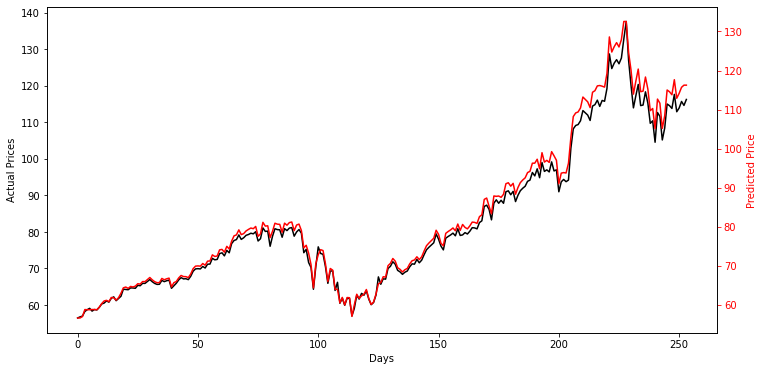

In [34]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_xlabel('Days')
ax1.set_ylabel('Actual Prices')
ax1.plot(Y, color = 'black')

ax2 = ax1.twinx()
ax2.set_ylabel('Predicted Price', color ='red')
ax2.plot(predict, color = 'red')
ax2.tick_params(axis='y', colors='red')
plt.show()

## Our model predicts prices pretty well based on the history of our chosen features. 

# Using LSTM to predict stock prices

In [35]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [36]:
df = pd.read_csv('MSFT.csv')        #Stock prices from 2015-11-25 to 2020-11-23. 5 years. 
df= df['Close']                     #Using Close prices for predictions        

Text(0, 0.5, 'PRICE OF STOCK')

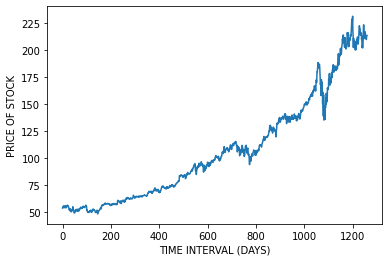

In [37]:
plt.plot(df)
plt.xlabel("TIME INTERVAL (DAYS)")
plt.ylabel("PRICE OF STOCK")

## The target value to be predicted is going to be the “Close” stock price value.

In [38]:
#Normalising the input values to feed into LSTM
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [39]:
#df = np.array(df)
train_size = int(len(df)*0.70)                        #Using 70 percent of dataset for training and rest for testing
test_size = (len(df)-train_size)
training = df[:train_size, :]
test = df[train_size:len(df), :]

In [40]:
training.shape,test.shape

((881, 1), (378, 1))

In [41]:
time_step = 50                                                #Using the last 50 days to predict price for the 51st day
X_train, Y_train, X_test, Y_test = [],[],[],[]
#Preprocessing 
#Preparing training and testing datasets compatible with LSTM
for i in range(len(training)-time_step):
    x = training[i:(i+time_step), 0]        
    X_train.append(x)
    Y_train.append(training[i+time_step,0])
for i in range(len(test)-time_step):
    x = test[i:(i+time_step), 0]
    X_test.append(x)
    Y_test.append(test[i+time_step,0])
X_train = np.array(X_train);
Y_train = np.array(Y_train);
X_test = np.array(X_test);
Y_test = np.array(Y_test);

In [42]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [43]:
X_train.shape, Y_train.shape

((831, 50, 1), (831,))

In [44]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer
model.add(LSTM(units = 50))
# Adding the output layer
model.add(Dense(units = 1))

opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)
# Compiling the RNN
model.compile(optimizer = opt,  loss = 'mean_squared_error')

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 50, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
____________________________________________________

In [46]:
model.fit(X_train, Y_train, epochs = 100, batch_size = 64)

Epoch 1/100
13/13 [==============================] - 1s 59ms/step - loss: 0.0163
Epoch 2/100
13/13 [==============================] - 1s 54ms/step - loss: 9.3319e-04
Epoch 3/100
13/13 [==============================] - 1s 56ms/step - loss: 4.2176e-04
Epoch 4/100
13/13 [==============================] - 1s 56ms/step - loss: 2.5999e-04: 0s - loss: 2.82
Epoch 5/100
13/13 [==============================] - 1s 65ms/step - loss: 2.6585e-04
Epoch 6/100
13/13 [==============================] - 1s 82ms/step - loss: 2.2315e-04
Epoch 7/100
13/13 [==============================] - 1s 74ms/step - loss: 2.1130e-04
Epoch 8/100
13/13 [==============================] - 1s 61ms/step - loss: 2.1064e-04
Epoch 9/100
13/13 [==============================] - 1s 66ms/step - loss: 2.0534e-04
Epoch 10/100
13/13 [==============================] - 1s 70ms/step - loss: 2.1895e-04
Epoch 11/100
13/13 [==============================] - 1s 63ms/step - loss: 2.0260e-04: 0s - loss: 2.10
Epoch 12/100
13/13 [=============

13/13 [==============================] - 1s 72ms/step - loss: 1.4676e-04
Epoch 96/100
13/13 [==============================] - 1s 65ms/step - loss: 1.3970e-04
Epoch 97/100
13/13 [==============================] - 1s 65ms/step - loss: 1.4278e-04
Epoch 98/100
13/13 [==============================] - 1s 62ms/step - loss: 1.5211e-04
Epoch 99/100
13/13 [==============================] - 1s 66ms/step - loss: 1.4018e-04
Epoch 100/100
13/13 [==============================] - 1s 56ms/step - loss: 1.5167e-04


In [47]:
import tensorflow as tf
tf.__version__


'2.3.1'

In [48]:
testpred=model.predict(X_test)
testpred=scaler.inverse_transform(testpred)
trainpred = model.predict(X_train)
trainpred = scaler.inverse_transform(trainpred)

In [49]:
math.sqrt(mean_squared_error(Y_train,trainpred))
math.sqrt(mean_squared_error(Y_test,testpred))

168.10726990512177

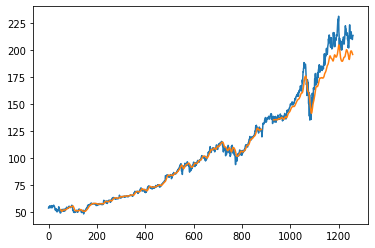

In [50]:
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(Y_train)-2+(50*2)+1:len(df)-1, :] = testpred
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
testPredictPlot[50:len(Y_train)+50, :] = trainpred
plt.plot(scaler.inverse_transform(df))
plt.plot(testPredictPlot)
plt.plot(trainPredictPlot)
plt.show()

# Predicting for the next 30 days using the previous time step of 50

In [51]:
f=test[(len(test)-50):,:].reshape(1,-1)
print(f.shape)
X=list(f)
X=X[0].tolist()

(1, 50)


### The cell code below takes the last 50 days and uses it to predict 51st day. It then appends the 51st day prediction to the dataset and predicts the 52nd day using last 50 days from the 52nd day, this includes the predicted price of the 51st day. 
### This happens for as many days as you want to predict, here, 30. 

In [52]:
output= []
for i in range(30):
    if (len(X)>50):
        f = np.array(X[-50:])
        f = f.reshape(1,-1)
        f = f.reshape((1, 50, 1))
        yhat = model.predict(f) 
        X.extend(yhat[0].tolist())
        output.extend(yhat.tolist())
    else:
        f = f.reshape((1,50,1))
        yhat = model.predict(f) 
        X.extend(yhat[0].tolist())
        output.extend(yhat.tolist())
print(output)

[[0.8049823641777039], [0.8006535768508911], [0.793199896812439], [0.7831699848175049], [0.7714911699295044], [0.7590938806533813], [0.7467261552810669], [0.7348908185958862], [0.7238583564758301], [0.7137165665626526], [0.7044328451156616], [0.6959097385406494], [0.6880282163619995], [0.68067467212677], [0.6737540364265442], [0.667194128036499], [0.6609427332878113], [0.65496426820755], [0.6492336392402649], [0.6437325477600098], [0.6384472250938416], [0.6333653330802917], [0.6284757256507874], [0.6237684488296509], [0.6192337870597839], [0.6148626208305359], [0.610646665096283], [0.6065775156021118], [0.6026486754417419], [0.5988526940345764]]


Text(0, 0.5, 'PRICE OF STOCK')

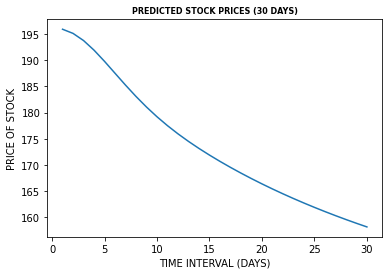

In [53]:
new = np.arange(1,31)
plt.plot(new,scaler.inverse_transform(output))
plt.title("PREDICTED STOCK PRICES (30 DAYS)", fontsize=8, fontweight='bold')
plt.xlabel("TIME INTERVAL (DAYS)")
plt.ylabel("PRICE OF STOCK")

In [54]:
len(df)

1259

Text(0, 0.5, 'PRICE OF STOCK')

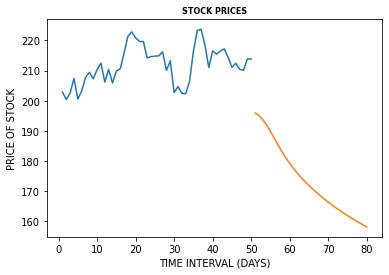

In [55]:
#Previous prices in Blue
#Predicted prices in Orange
old=np.arange(1,51)
new=np.arange(51,81)
plt.plot(old, scaler.inverse_transform(df[1209:]))
plt.plot(new, scaler.inverse_transform(output))
plt.title("STOCK PRICES", fontsize=8, fontweight='bold')
plt.xlabel("TIME INTERVAL (DAYS)")
plt.ylabel("PRICE OF STOCK")

Text(0, 0.5, 'PRICE OF STOCK')

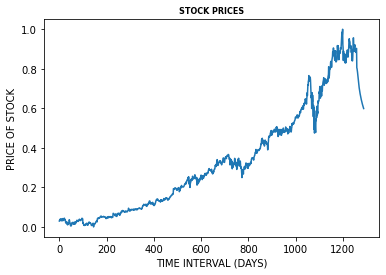

In [56]:
#Appending the predicted prices to the original dataset
df_graph = df.tolist()
df_graph.extend(output)
plt.plot(df_graph)
plt.title("STOCK PRICES", fontsize=8, fontweight='bold')
plt.xlabel("TIME INTERVAL (DAYS)")
plt.ylabel("PRICE OF STOCK")